# 深度学习可视化

## 4.可视化类激活热力图(CAM，class activation map)

"它是指对输入图像生成类激活的热力图。类激活热力图是与特定输出类别相关的二维分数网格，对任何输入图像的每个位置都要进行计算，它表示每个位置对该类别的重要程度。举例来说，对于输入到猫狗分类卷积神经网络的一张图像，CAM 可视化可以生成类别“猫”的热力图，表示图像的各个部分 与“猫”的相似程度，CAM 可视化也会生成类别“狗”的热力图，表示图像的各个部分与“狗”的相似程度。"

*Grad-CAM: visual explanations from deep networks via gradient- based localization*

"给定一张输入图像，对于一个卷积层的输出特征图，用类别相对于通道的梯度对这个特征图中的每个通道进行加权。直观上 来看，理解这个技巧的一种方法是，你是用“每个通道对类别的重要程度”对“输入图像对不 同通道的激活强度”的空间图进行加权，从而得到了“输入图像对类别的激活强度”的空间图。"

In [2]:
from keras.applications.resnet_v2 import ResNet50V2

model = ResNet50V2(weights='imagenet')

Instructions for updating:
Colocations handled automatically by placer.


In [28]:
from keras.preprocessing import image
from keras.applications.resnet_v2 import preprocess_input, decode_predictions
from keras import backend as K

import numpy as np

img_path = '../chapter-4/data/train/dog/dog.100.jpg'
img = image.load_img(img_path, target_size=(224, 224))

x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)

preds = model.predict(x)
print('Predicted:', decode_predictions(preds, top=3)[0])

Predicted: [('n02087394', 'Rhodesian_ridgeback', 0.59832233), ('n02099712', 'Labrador_retriever', 0.24176921), ('n02115641', 'dingo', 0.110947885)]


In [29]:
np.argmax(preds[0])

159

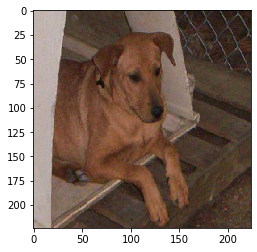

In [30]:
img_tensor = image.img_to_array(img)
img_tensor = np.expand_dims(img_tensor, axis=0)
img_tensor /= 255.

plt.imshow(img_tensor[0])
plt.show()

In [31]:
model.summary()

Model: "resnet50v2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
pool1_pad (ZeroPadding2D)       (None, 114, 114, 64) 0           conv1_conv[0][0]                 
_________________________________________________________________________________________

### 应用 Grad-CAM 算法

In [32]:
african_elephant_output = model.output[:, 386]
last_conv_layer = model.get_layer('conv5_block3_3_conv')
grads = K.gradients(african_elephant_output, last_conv_layer.output)[0]
pooled_grads = K.mean(grads, axis=(0, 1, 2))

iterate = K.function([model.input],
                     [pooled_grads,last_conv_layer.output[0]])

pooled_grads_value, conv_layer_output_value = iterate([x])

for i in range(512):
    conv_layer_output_value[:, :, i] *= pooled_grads_value[i]
    
heatmap = np.mean(conv_layer_output_value, axis=-1)

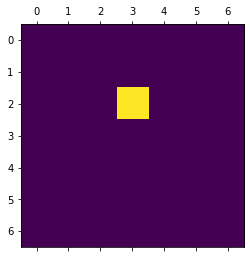

In [33]:
import matplotlib.pyplot as plt

# 热力图后处理
heatmap = np.maximum(heatmap, 0)
heatmap /= np.max(heatmap)
plt.matshow(heatmap)

### 叠加原图与热力图

In [35]:
import cv2

img = cv2.imread(img_path)

heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
heatmap = np.uint8(255 * heatmap)
heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)

superimposed_img = heatmap * 0.4 + img

cv2.imwrite('dog_cam.jpg', superimposed_img)

True